<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/Exploration_quest/exploration_2/xp2_news_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4-1. 프로젝트: 뉴스기사 요약해보기

**Index**
    
    1. Set up
    2. 데이터 준비
    3. 데이터 전처리 (1) 텍스트 정규화와 불용어 제거
    4. 데이터 전처리 (2) 훈련 데이터와 테스트 데이터 분리하기
    5. 데이터 전처리 (3) 정수 인코딩
    6. 모델 설계 (1) 인코더와 디코더
    7. 모델 설계 (1) 어텐션 메커니즘
    8. 모델 훈련
    9. 인퍼런스 모델 구현
    10. 모델 테스트
    11. Summa을 활용한 추출적 요약

### 1. Set up

In [ ]:
from importlib.metadata import version

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow
import summa
import pandas as pd

print("NLTK version:", nltk.__version__)
print("TensorFlow version:", tensorflow.__version__)
print("Pandas version:", pd.__version__)
print("Summa version:", version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NLTK version: 3.6.5
TensorFlow version: 2.6.0
Pandas version: 1.3.3
Summa version: 1.2.0


### 2. 데이터 준비

뉴스 기사 데이터 [news_summary_more.csv](https://github.com/sunnysai12345/News_Summary)를 사용하겠습니다.

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

샘플을 확인해 볼까요?

In [ ]:
data.sample(10)

,headlines,text
2038,She's in fridge: Hawaii man told police after ...,Yu Wei Gong from Hawaii has been sentenced to ...
1545,Faulkner hits 16 off last over's 1st 3 balls t...,Hobart Hurricanes' Australian cricketer James ...
6253,India captain Kohli pulls off a one-handed fly...,"India captain Virat Kohli, while fielding at s..."
72809,Bidhuri seals India's 1st medal at World Boxin...,Indian boxer Gaurav Bidhuri assured India its ...
65793,India's only scorer in FIFA World Cup not paid...,Eight Manipuri players in the India U-17 World...
47933,Rahul calling himself 'janeudhari' is a victor...,Uttar Pradesh CM Yogi Adityanath on Tuesday sa...
96680,"Yepme employees allege salary delays, forced r...",A group of six Yepme employees has approached ...
46686,Nirav Modi's aide Vipul Ambani was aware of fr...,The CBI has said that Nirav Modi's aide Vipul ...
46333,"Chidambaram accuses CBI, ED of harassment in S...",Accusing the CBI and the ED of harassing him a...
13199,Rupee rises to two-week high against dollar,The Indian rupee rose to a two-week high of 73...


본 데이터는 뉴스 기사의 본문과 제목에 해당되는 `text`와 `headlines` 두 가지 열로 구성되어 있습니다.  

**중복 샘플과 NULL 값이 존재하는 샘플 제거**

데이터의 중복 샘플 유무를 확인해 봅시다.

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복된 샘플를 제외하면 text에는 `98,360개`, headlines에는 `98,280개`의 유니크한 데이터가 존재합니다.  
데이터 프레임의 `drop_duplicates()`를 사용하여 중복된 샘플을 제거하겠습니다.

In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


전체 샘플 수는 `98,360개` 입니다. 그런데 만약 데이터에 Null 값을 가지는 샘플이 있다면? `drop_duplicates()`으로 중복된 Null 값이 지워지긴 하겠지만, 여전히 어딘가에 Null값이 남아있을 수 있어요. `.isnull().sum()`을 사용하여 데이터에 Null값이 남아있는지 확인해 봅시다.

In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null값이 없습니다. 따라서 전체 샘플 수는 `98,360개` 입니다.

### 3. 데이터 전처리 (1) 텍스트 정규화와 불용어 제거

같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우는 어떻게 처리할까요? 예를 들어서 it'll 은 it will 과 같고, mustn't 과 must not 은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 정리하는 것이 기계의 연산량을 줄일 수 있습니다. 이러한 방법론을 텍스트 정규화 `text normalization` 라고 합니다.

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재합니다. 이를 불용어 `stopwords` 라고 합니다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있습니다. NLTK에서 제공하는 불용어 리스트를 참조해 샘플에서 불용어를 제거하겠습니다.

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 `179개` 입니다. 이를 사용하여 불용어를 제거하겠습니다. 이 작업 외에도 모든 `영어 문자는 소문자로` 만들고, 섞여 있는 `html 태그를 제거`하고, 정규 표현식을 통해 각종 `특수문자를 제거`해서 필요한 내용만 학습할 수 있도록 처리하겠습니다. NLTK를 이용해 불용어를 제거하는 파트가 있는데 이는 Text 전처리 시에서만 호출하고, 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 거에요. 추상적인 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 `text`에는 남아 있는 게 더 좋습니다. 이를 위해서 `remove_stopwords`와 `if`문을 추가하겠습니다.

In [ ]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print("Gotcha")

Gotcha


전처리 전후의 결과를 확인하기 위해서 임의의 text와 headline을 만들어 함수를 호출해 볼까요?

In [ ]:
import re
from bs4 import BeautifulSoup

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start new day'

print("text:", preprocess_sentence(temp_text))
print("headline:", preprocess_sentence(temp_headline, False))

text: everything bought great infact ordered twice third ordered wasfor mother father
headline: great way to start new day


In [ ]:
# text 데이터 전처리

clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
# headlines 데이터 전처리

clean_headlines = []

for headline in data['headlines']:
    clean_headlines.append(preprocess_sentence(headline, False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈 샘플이 생겼는지 확인하는 것이 좋습니다. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈값을 가지게 되겠죠? 데이터들을 쉽게 확인하기 위해 데이터 프레임에 다시 저장하겠습니다. 빈값을 가진 샘플들이 있다면 모두 Null 값을 가진 샘플로 대체하겠습니다.

In [ ]:
import numpy as np

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace = True)

print("Yar")

Yar


`.isnull().sum()`을 사용해서 Null값이 생겼는지 확인해 봅시다.

In [ ]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

데이터가 잘 정리되었습니다. 다음으로 가봅시다!

### 4. 데이터 전처리 (2) 훈련 데이터와 테스트 데이터 분리하기

**샘플의 최대 길이 정하기**

원본 데이터에서 필요 없는 단어를 모두 정리했습니다. 이제 훈련에 사용할 샘플의 최대 길이를 임의로 정하겠습니다.  
`text`와 `headlines`의 최소 / 최대 / 평균 길이를 구하고, 길이의 분포를 시각화하여 확인해 봅시다.

text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.09968483123221
headlines 최소 길이 : 1
headlines 최대 길이 : 16
headlines 평균 길이 : 9.299532330215534


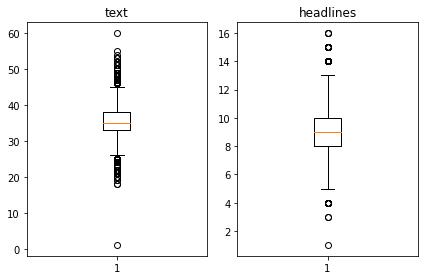

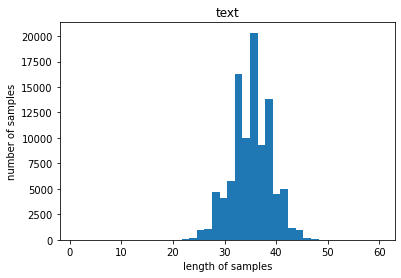

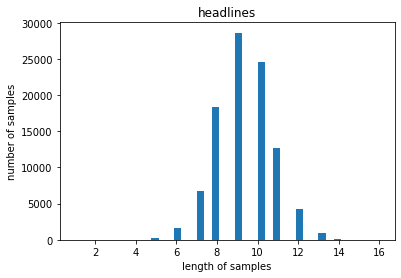

In [ ]:
# 길이 분포 출력

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('text 최소 길이 : {}'.format(np.min(text_len)))
print('text 최대 길이 : {}'.format(np.max(text_len)))
print('text 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 최소 길이 : {}'.format(np.min(summary_len)))
print('headlines 최대 길이 : {}'.format(np.max(summary_len)))
print('headlines 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서부터 차례대로 그래프는 각각 `실제 텍스트와 제목의 길이 분포`, `실제 텍스트 샘플 길이 별 개수`, `제목 샘플 길이 별 개수`를 나타내고 있어요.

text의 경우 최소 길이가 1, 최대 길이가 60입니다. 평균 길이는 35로 시각화 된 그래프로 봤을 때 대체적으로는 25에서 35 사이의 길이임을 확인할 수 있습니다. headlines의 경우, 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 짧습니다. 그래프로 봤을 때에도 대체적으로 13 이하의 길이를 가지고 있네요. 이 결과를 바탕으로 text의 최대 길이와 headlines의 적절한 최대 길이를 아래와 같이 임의로 정하겠습니다.

In [ ]:
text_max_len = 40
headlines_max_len = 15

print("Yar")

Yar


각각 `40`과 `15`로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하면 객관적으로 길이를 결정하는 데 도움이 될 거예요.  
훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해 봅시다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

print("Yar")

Yar


이렇게 만든 함수를 `text`와 `headlines`에 적용해 우리가 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 확인해 봅시다.

In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


각각 40과 15로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, text 열의 경우에는 약 8%의 샘플들의 내용이 망가질 수 있습니다.  
정해진 길이에 샘플 데이터를 맞춰 자르는 않고, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하겠습니다.

In [ ]:
# apply 함수와 lamda식을 사용하여 text와 headlines을 담고 있는 data 데이터 프레임을
# 위에서 임의로 정의한 text_max_len과 headlines_max_len의 길이보다 큰 샘플을 제외

text_max_len = 40
headlines_max_len = 15

data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headlines_max_len, axis = 1)]

print('전체 샘플수 (최대 길이 이하):', len(data))

전체 샘플수 (최대 길이 이하): 90869


**시작 토큰과 종료 토큰 추가하기**

`seq2seq` 훈련을 위해서는 디코더의 입력과 레이블에 `시작 토큰`과 `종료 토큰`을 추가해야 합니다. 시작 토큰은 `sostoken`, 종료 토큰은 `eostoken` 이라 임의로 명명하고 앞뒤로 추가하겠습니다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target` 이라고 정하겠습니다. 두 개의 문장 모두 `headlines` 열로부터 만들 거예요.

In [ ]:
# headlines 데이터에 시작 토큰과 종료 토큰 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


앞뒤로 토큰이 잘 추가되었습니다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 `Numpy` 타입으로 저장하겠습니다.

In [ ]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

이제 훈련 데이터와 테스트 데이터를 분리하겠습니다. 우선, encoder_input과 크기와 형태는 같지만 순서가 섞인 `정수 시퀀스`를 만들어 봅시다.

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[54424 16007 72018 ... 84224 14835 13824]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠?

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이렇게 섞인 데이터를 `8:2의 비율`로 훈련 데이터와 테스트 데이터로 분리하겠습니다. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 봅시다.

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18173


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분하겠습니다.

In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 72696
훈련 레이블의 개수 : 72696
테스트 데이터의 개수 : 18173
테스트 레이블의 개수 : 18173


훈련 데이터와 테스트 데이터가 각각 `72,696개`와 `18,173개`로 잘 분리되었습니다.

### 5. 데이터 전처리 (3) 정수 인코딩

**단어 집합 만들기 및 정수 인코딩**

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변환해야 합니다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요합니다. 이 과정을 단어 집합 `Vocabulary`을 만든다 라고 표현합니다. 훈련 데이터에 대해서 단어 집합을 만들어 봅시다. 우선, 원문에 해당하는 `encoder_input_train`에 대해서 단어 집합을 만들어 봅시다. Keras의 `Tokenizer()`를 사용하면 입력된 훈련 데이터로부터 단어 집합을 만들 수 있습니다.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

print("Gotcha")

Gotcha


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어 있습니다. 하지만 단어 집합에 있는 모든 단어를 사용하지 않을 거예요. 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려 합니다. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 어떤 비중을 차지하는지 확인해 봅시다. 단어와 각 단어의 등장 빈도수가 저장되어 있는 `src_tokenizer.word_counts.items()`로 통계적인 정보를 확인해 봅시다.

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65736
등장 빈도가 6번 이하인 희귀 단어의 수: 44732
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21004
단어 집합에서 희귀 단어의 비율: 68.04794937325059
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6344796956642034


단어 집합의 크기는 `65,863개`이며, 등장 빈도가 6회 이하인 희귀 단어는 `44,821개` 있습니다. 이들을 제외할 경우, 단어 집합의 크기는 `21,042개`가 됩니다. 희귀 단어의 비율은 단어 집합에서 약 `68.05%`를 차지하며, 전체 등장 빈도에서 희귀 단어가 차지하는 비율은 약 `3.64%` 입니다.

여기서 등장 빈도가 6회 이하인 단어들은 전체 단어 집합 중 약 `68%`를 차지하지만, 실제 훈련 데이터에서의 등장 빈도 비율은 약 `3.64%`로 매우 적은 비중을 차지합니다. 따라서 이러한 희귀 단어들을 제외하고, 훈련 데이터에서 제거하여 모델 학습에 미치는 영향을 최소화할 수 있습니다.

그래서 단어 집합의 크기를 제한하기 위해 토크나이저의 `num_words` 값을 희귀 단어를 제외하고 재구성된 단어 집합의 크기인 `21,042`를 고려하여 num_words 값을 설정하겠습니다. 이렇게 하면 모델 학습 시 사용하는 단어의 수를 제한하여 효과적인 훈련을 진행할 수 있습니다.

In [ ]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

print("Gotcha")

Gotcha


`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행합니다.  
현재 단어 집합의 크기를 `20,000`으로 제한했으므로 이제 숫자 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않겠죠?

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1481, 8166, 316, 478, 671, 15, 8582, 6299, 61, 23, 974, 41, 788, 6225, 1758, 361, 5941, 63, 89, 8, 218, 106, 6225, 795, 644, 218, 6375, 15, 6299, 1, 3440, 2567, 600, 1630, 3933, 158], [159, 501, 7636, 132, 4652, 8055, 454, 260, 1, 173, 4134, 1469, 2658, 173, 63, 1379, 1, 115, 746, 129, 287, 277, 311, 623, 382, 1, 457, 432, 576, 1482, 119, 173], [43, 112, 177, 719, 2369, 685, 1695, 730, 170, 4915, 1275, 2361, 118, 106, 280, 8, 170, 2361, 685, 112, 177, 81, 4741, 1411, 2124, 9886, 1569, 43, 441, 522, 36, 1505, 992]]


이제 더 이상 텍스트 데이터가 아니라 정수가 보이고 있습니다. `headlines` 데이터에 대해서도 동일한 작업을 수행하겠습니다.  
케라스의 토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해 봅시다.

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

print("Gotcha")

Gotcha


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 `tar_tokenizer.word_index`에 저장되어 있어요.  `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어 있는데, 통계적인 정보를 바탕으로 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해 봅시다.

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28907
등장 빈도가 5번 이하인 희귀 단어의 수: 18931
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9976
단어 집합에서 희귀 단어의 비율: 65.48932784446674
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.838634309417861


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 `65%`를 차지하고 있습니다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 `4.87%` 정도 입니다. 앞서 진행했던 것과 동일하게 이 단어들은 모두 제거하겠습니다. 어림잡아 `9,000`을 단어 집합의 크기로 제한할게요.

In [ ]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 354, 76, 2449, 5, 3359, 8, 4, 929], [1, 3674, 260, 239, 9, 3056, 97, 3469, 73], [1, 100, 799, 2395, 13, 563, 195, 374], [1, 117, 651, 62, 26, 983, 113, 3, 152, 245, 352], [1, 14, 822, 100, 6, 769, 1243, 402, 8, 40, 5, 61]]
target
decoder  [[354, 76, 2449, 5, 3359, 8, 4, 929, 2], [3674, 260, 239, 9, 3056, 97, 3469, 73, 2], [100, 799, 2395, 13, 563, 195, 374, 2], [117, 651, 62, 26, 983, 113, 3, 152, 245, 352, 2], [14, 822, 100, 6, 769, 1243, 402, 8, 40, 5, 61, 2]]


정수 인코딩 작업이 끝났습니다. 현재 `decoder_input_train`과 `decoder_target_train`에는 더 이상 9,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 `패딩`으로 넘어가기 전에 한 가지 점검해야 할 것이 있어요. 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈 샘플이 되었을 가능성이 있습니다. 이 현상은 길이가 상대적으로 길었던 원문 text의 경우에는 문제가 없겠지만, 애초에 평균 길이가 9 정도 밖에 되지 않았던 headllines의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠?

요약문에서 길이가 0이 된 샘플들의 인덱스를 받겠습니다. 여기서 주의할 점은 요약문인 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로, 단어 집합 제한에도 삭제되지 않을 수 있습니다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이가 0이 된 `decoder_input`에는 `sostoken`, `decoder_target`에는 `eostoken`만 남아 있을 테니까요. 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장하겠습니다. 이 샘플들은 모두 삭제할 거예요.

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 72695
훈련 레이블의 개수 : 72695
테스트 데이터의 개수 : 18173
테스트 레이블의 개수 : 18173


테스트 데이터에서 한 개의 샘플이 제거된 것을 확인할 수 있어요. 이제 거의 다 왔어요!

**패딩하기**

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬로 처리하기 위해 같은 길이로 맞춰주는 패딩 작업이 필요합니다. 앞서 정해두었던 최대 길이로 패딩을 진행하겠습니다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춥니다.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

print("Are you ready?")

Are you ready?


### 6. 모델 설계 (1) 인코더와 디코더

모델을 설계하겠습니다. 우선 함수형 API를 이용해서 인코더를 설계해 봅시다.

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1, initial_state=[state_h1, state_c1])

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2, initial_state=[state_h2, state_c2])

`recurrent dropout`을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다. recurrent dropout에 대한 자세한 내용은 [Recurrent Dropout without Memory Loss](https://arxiv.org/pdf/1603.05118v2.pdf) 논문을 참고하세요. 이제 디코더를 설계해 봅시다.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일합니다. 하지만 LSTM의 입력을 정의할 때, `initial_state`의 인자값으로 인코더의 `hidden state`와 `cell state`의 값을 삽입해야 합니다. 디코더의 출력층을 설계해 봅시다.

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 text의 단어장인 tar_vocab의 수 많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 합니다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용합니다. 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 `seq2seq` 입니다. 그런데 디코더의 출력층 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있습니다? 바로 `어텐션 메커니즘`.

### 7. 모델 설계 (1) 어텐션 메커니즘

`어텐션 메커니즘`을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 의미입니다. 저는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 확인하려 합니다. 참고로 사용하고자 하는 어텐션 함수는 `Bahdanau 스타일의 어텐션`입니다. 이 어텐션에 대한 자세한 설명은 [텐서플로우 홈페이지](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)를 참고하세요. 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있습니다.

### 8. 모델 훈련

앞서 설계한 모델로 훈련을 진행해 봅시다.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
284/284 [==============================] - 141s 377ms/step - loss: 4.5071 - val_loss: 4.1580
Epoch 2/50
284/284 [==============================] - 107s 376ms/step - loss: 4.0804 - val_loss: 3.8850
Epoch 3/50
284/284 [==============================] - 108s 381ms/step - loss: 3.7856 - val_loss: 3.6456
Epoch 4/50
284/284 [==============================] - 108s 380ms/step - loss: 3.5732 - val_loss: 3.4951
Epoch 5/50
284/284 [==============================] - 107s 378ms/step - loss: 3.4103 - val_loss: 3.3897
Epoch 6/50
284/284 [==============================] - 107s 377ms/step - loss: 3.2742 - val_loss: 3.3010
Epoch 7/50
284/284 [==============================] - 107s 378ms/step - loss: 3.1561 - val_loss: 3.2305
Epoch 8/50
284/284 [==============================] - 106s 375ms/step - loss: 3.0508 - val_loss: 3.1674
Epoch 9/50
284/284 [==============================] - 106s 374ms/step - loss: 2.9585 - val_loss: 3.1312
Epoch 10/50
284/284 [==============================] - 106s 372m

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화하여 확인해 봅시다!

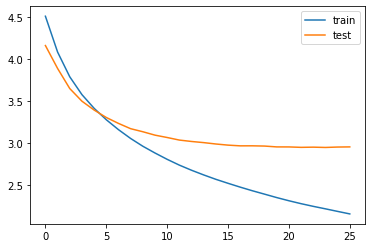

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 9. 인퍼런스 모델 구현

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print("Gotcha")

Gotcha


**`seq2seq`는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로, 그에 맞게 모델 설계를 별개로 진행합니다.**

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한 번에 넣어야 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 모델 하나만 준비합니다. 그러나 정답 문장이 없는 인퍼런스 단계에서는 생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하므로 부득이 인퍼런스를 위한 모델을 별도로 설계해야 합니다. 이 때에는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print("Gotcha")

Gotcha


어텐션 메커니즘을 사용하는 출력층을 설계해 봅시다.

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print("Gotcha")

Gotcha


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어 볼까요?

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

print("Gotcha")

Gotcha


### 10. 모델 테스트

원래의 요약문(text 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교하겠습니다. 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠? 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어 봅시다. 함수를 만들 때, test의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고, headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [ ]:
# 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수
# 요약문에는 sostoken과 eostoken을 고려

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp += tar_index_to_word[i] + ' '
    return temp

print("Gotcha")

Gotcha


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해 봅시다.

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : haryana education minister ram sharma addressing students haridwar said believe google says believe vedas also said sanskrit scholar better mbbs graduate mbbs lose job sanskrit scholar become pandit perform several occasions added 
실제 요약 : do not believe google believe in haryana education minister 
예측 요약 :  will not be compulsory in up if it is not in my life bjp


원문 : icici bank ceo chanda kochhar brother law rajiv kochhar said financial services firm advisory group business arrangements icici bank added guy trying create something clarification comes bjp leader subramanian swamy called probe dealings icici bank 
실제 요약 : chanda kochhar brother in law denies biz links with icici 
예측 요약 :  icici board denies reports of chanda kochhar over life row


원문 : delhi commission women chief swati maliwal asked husband aap leader naveen jaihind control anger public saying needs careful speaking condemning haryana government lakh compensation rewari gangrape victim jaihind said give lakh b

In [ ]:
print("원문 :", seq2text(encoder_input_test[0]))
print("실제 요약 :", seq2headlines(decoder_input_test[0]))
print("예측 요약 :", decode_sequence(encoder_input_test[0].reshape(1, text_max_len)))
print("\n")

원문 : nba side oklahoma city thunder russell tried trade shoe pizza slice child attending thunder match phoenix suns videos showed child took shoe refused hand pizza nba player later talked pizza shoe trade asked reporter 
실제 요약 : nba player tries to exchange his shoe for kid pizza 
예측 요약 :  player wears tennis player to score player from his own




많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보입니다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있습니다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 좋지 않은 요약의 예도 꽤나 보입니다. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보겠습니다.

### 11. Summa을 활용한 추출적 요약

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높습니다.  
반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고, 기존 문장에서 문장을 가져오는 것이므로 잘못된 요약이 나올 가능성이 낮습니다.

`Summa`의 `summarize`를 사용하여 추출적 요약을 진행하겠습니다.

In [ ]:
# 데이터 다운로드하기

import requests
from summa.summarizer import summarize

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
new_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
new_data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 90869


In [ ]:
print(new_data.isnull().sum())

headlines    0
text         0
dtype: int64


In [ ]:
from summa.summarizer import summarize

text_for_extraction_summary = new_data['text'][0]

extractive_summary = summarize(text_for_extraction_summary, ratio=0.8)

print("Extractive Summary:")
print(extractive_summary)

Extractive Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [ ]:
print(extractive_summary[:1500])

The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


**summarize 사용하기**

`Summa`의 `summarize()`에 인자로 사용되는 값들에 대해서 알아 봅시다.

* text (str) - 요약할 텍스트.
* ratio (float, optional) – 요약문과 원본에서 선택되는 문장의 비율. 0~1 사이의 값.
* words (int or None, optional) – 출력에 포함할 단어의 수.
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시합니다.
* split (bool, optional) – True면 문장 list, False는 조인(join)된 문자열을 반환.

`Summa`의 `summarize`는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다. 그렇기에 문장 구분이 되어있지 않은 원문의 형태를 입력으로 바로 적용할 수 있습니다. 비율을 적게 설정해서 요약문으로 선택되는 문장의 개수를 줄여보겠습니다. 원문의 0.8%을 출력하도록 설정해 봅시다.

In [ ]:
print('Summary:')
print(summarize(extractive_summary, ratio=0.8))

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 설정하면 되겠죠?

In [ ]:
print('Summary:')
print(summarize(extractive_summary, ratio=0.8, split=True))

Summary:
["The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike."]


단어의 수로 요약문의 크기를 조절할 수 있습니다. 단어를 20개만 선택하겠습니다.

In [ ]:
print('Summary:')
print(summarize(extractive_summary, words=20))

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.


In [ ]:
import requests
from summa import keywords

print(keywords.keywords(extractive_summary))

hike
upgrad
salary


뉴스 기사 데이터 [news_summary_more.csv](https://github.com/sunnysai12345/News_Summary)를 사용하여 `Extractive/Abstractive summarization`를 이해하기 위해 위와 같이 단어장 크기를 줄이는 다양한 `text normalization` 적용하여 자연어 처리 작업을 실습하였고, `seq2seq` 모델의 성능을 향상시키는 `Attention Mechanism` 적용해 봤습니다. 실험 과정과 결과에 대한 회고는 xp2_retrospect.ipynb 파일에 정리했습니다.